# Imports

In [ ]:
!pip install -q -U transformers accelerate bitsandbytes peft

In [10]:
import os
import json
import numpy as np
import pandas as pd
import torch
import gc
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score
from scipy.stats import spearmanr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Configuration

In [15]:
MODEL_NAME = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
MAX_LEN = 384
BATCH_SIZE = 16
LR = 2e-5
EPOCHS_PER_FOLD = 2  
N_FOLDS = 5
CONFIDENCE_THRESH = 0.90
ACCUM_STEPS = 1
SEED = 42

In [ ]:
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")

# Preparing the data

In [16]:
PATH_VAL = "/kaggle/input/shroom-aware/val.model-aware.v2.json"
PATH_TRIAL = "/kaggle/input/shroom-aware/trial-v1.json"
PATH_TEST = "/kaggle/input/shroom-aware/test.model-aware.json"
PATH_TRAIN_JSON = "/kaggle/input/shroom-aware/train.model-aware.v2.json"
PATH_TRAIN_CSV = "/kaggle/input/shroom-aware/train.model-aware-combined.v2.csv"

def load_data():
    with open(PATH_VAL) as f: val_df = pd.DataFrame(json.load(f))
    with open(PATH_TRIAL) as f: trial_df = pd.DataFrame(json.load(f))
    with open(PATH_TEST) as f: test_df = pd.DataFrame(json.load(f))
    
    with open(PATH_TRAIN_JSON) as f: pseudo_json = pd.DataFrame(json.load(f))
    pseudo_csv = pd.read_csv(PATH_TRAIN_CSV)
    
    # Prepare Pseudo Data
    pseudo_df = pseudo_json.copy()
    pseudo_df['p_hallucination'] = pseudo_csv['p_hallucination']
    
    # Filter for high confidence only
    mask = (pseudo_df["p_hallucination"] > CONFIDENCE_THRESH) | \
           (pseudo_df["p_hallucination"] < (1 - CONFIDENCE_THRESH))
    pseudo_df = pseudo_df[mask].copy()
    pseudo_df['label_bin'] = (pseudo_df['p_hallucination'] > 0.5).astype(int)
    
    # Prepare Gold Data (Val + Trial)
    # Fix empty model names in trial
    trial_df['model'] = trial_df['model'].replace('', 'unknown')
    
    # Keep consistent columns
    cols = ['hyp', 'ref', 'src', 'tgt', 'model', 'task', 'label']
    gold_df = pd.concat([val_df[cols], trial_df[cols]], ignore_index=True)
    
    # Map Labels
    label_map = {'Hallucination': 1, 'Not Hallucination': 0}
    gold_df['label_bin'] = gold_df['label'].map(label_map)
    if 'label' in test_df.columns:
        test_df['label_bin'] = test_df['label'].map(label_map).fillna(0).astype(int)
        
    return gold_df, pseudo_df, test_df

gold_df, pseudo_df, test_df = load_data()
print(f"Gold Data (Val+Trial): {len(gold_df)} rows")
print(f"Pseudo Data (Filtered): {len(pseudo_df)} rows")
print(f"Test Data: {len(test_df)} rows")

Gold Data (Val+Trial): 581 rows
Pseudo Data (Filtered): 26486 rows
Test Data: 1500 rows


In [ ]:
def create_context(row):
    task = str(row.get("task", "UNK"))
    model_raw = str(row.get("model", "UNK"))
    # Handle empty or missing model names
    if not model_raw or model_raw == "nan": model_raw = "unknown"
    model_name = model_raw.split("/")[-1]
    
    # Logic to pick reference
    ref_col = row.get("ref", "tgt")
    reference = str(row.get("tgt", "")) if ref_col == "tgt" else str(row.get("src", ""))
    source = str(row.get("src", ""))
    
    return f"Task: {task} | Model: {model_name} | Ref: {reference} | Src: {source}"

print("Building contexts...")
for df in [gold_df, pseudo_df, test_df]:
    df['context_input'] = df.apply(create_context, axis=1)
    df['hyp'] = df['hyp'].fillna("").astype(str)

In [ ]:
class ShroomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, has_labels=True):
        self.context = df['context_input'].values
        self.hyp = df['hyp'].values
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.has_labels = has_labels
        if self.has_labels:
            self.labels = df['label_bin'].values

    def __len__(self):
        return len(self.context)

    def __getitem__(self, index):
        encoding = self.tokenizer(
            self.context[index],
            self.hyp[index],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt',
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten()
        }
        if self.has_labels:
            item['labels'] = torch.tensor(self.labels[index], dtype=torch.long)
        return item

# Deberta

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Placeholder for OOF predictions and Test predictions
oof_preds = np.zeros(len(gold_df))
test_preds_accum = np.zeros(len(test_df)) 

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(gold_df, gold_df['label_bin'])):
    print(f"\n{'='*15} FOLD {fold+1}/{N_FOLDS} {'='*15}")
    
    fold_train_gold = gold_df.iloc[train_idx]
    fold_val_gold = gold_df.iloc[val_idx]
    
    train_combined = pd.concat([fold_train_gold, pseudo_df], ignore_index=True)
    
    train_ds = ShroomDataset(train_combined, tokenizer, MAX_LEN)
    val_ds = ShroomDataset(fold_val_gold, tokenizer, MAX_LEN)
    test_ds = ShroomDataset(test_df, tokenizer, MAX_LEN, has_labels=False)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, ignore_mismatched_sizes=True)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    # Calculate class weights for this fold to handle imbalance
    n_samples = len(train_combined)
    n_classes = 2
    count = train_combined['label_bin'].value_counts().sort_index().values
    weights = torch.tensor(n_samples / (n_classes * count), dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    
    scaler = GradScaler()
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, 
        num_training_steps=len(train_loader) * EPOCHS_PER_FOLD
    )
    
    best_val_score = 0
    best_model_state = None
    
    for epoch in range(EPOCHS_PER_FOLD):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}", leave=False)
        
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            token_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids, attention_mask=mask, token_type_ids=token_ids)
                loss = criterion(outputs.logits, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
        model.eval()
        val_probs = []
        val_true = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                token_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)
                
                out = model(input_ids, attention_mask=mask, token_type_ids=token_ids)
                probs = torch.softmax(out.logits, dim=1)[:, 1]
                val_probs.extend(probs.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        val_f1 = f1_score(val_true, (np.array(val_probs) > 0.5).astype(int))
        val_acc = accuracy_score(val_true, (np.array(val_probs) > 0.5).astype(int))
        print(f"   Epoch {epoch+1}: Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
        
        if val_f1 > best_val_score:
            best_val_score = val_f1
            best_model_state = model.state_dict()
    
    print(f"   Generating predictions for Fold {fold+1}...")
    model.load_state_dict(best_model_state)
    model.eval()

    fold_test_probs = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            token_ids = batch['token_type_ids'].to(device)
            out = model(input_ids, attention_mask=mask, token_type_ids=token_ids)
            probs = torch.softmax(out.logits, dim=1)[:, 1]
            fold_test_probs.extend(probs.cpu().numpy())
            
    test_preds_accum += np.array(fold_test_probs)
    
    del model, optimizer, scheduler, scaler
    torch.cuda.empty_cache()
    gc.collect()

print("\n" + "="*30)
print("CALCULATING FINAL PREDICTIONS")
print("="*30)

# Average predictions
avg_test_probs = test_preds_accum / N_FOLDS

submission_deb = pd.DataFrame({
    'id': test_df['id'],
    'deberta_prob': avg_test_probs
})

output_file = "submission_deberta.csv"
submission_deb.to_csv(output_file, index=False)
print(submission_deb.head())


### Evaluate test values

Best Threshold: 0.15
Best Accuracy: 0.7473
F1 Score: 0.6015
Spearman: 0.5021


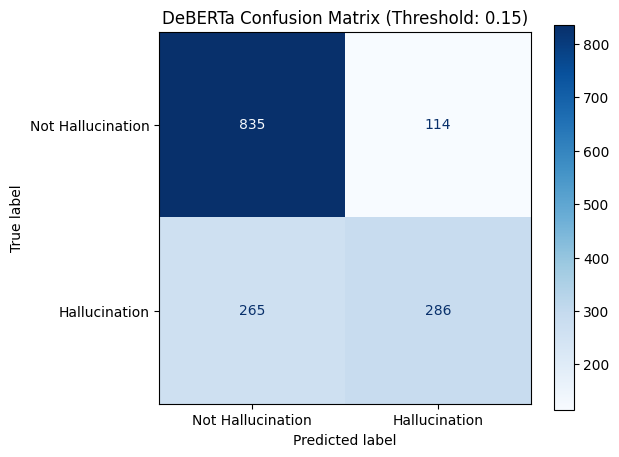

In [13]:
df_deb = pd.read_csv("/kaggle/input/ensemble-probs/submission_deberta.csv")
df_deb['id'] = np.arange(len(df_deb))

df_deb['score'] = df_deb['deberta_prob']   # rename for clarity

with open("/kaggle/input/shroom-aware/test.model-aware.json") as f:
    test_data = pd.DataFrame(json.load(f))

label_map = {'Hallucination': 1, 'Not Hallucination': 0}
y_true = test_data['label'].map(label_map).fillna(0).astype(int).values

best_acc = 0
best_thresh = 0.5
thresholds = np.linspace(0.1, 0.9, 81)

for t in thresholds:
    preds = (df_deb['score'] > t).astype(int)
    acc = accuracy_score(y_true, preds)

    if acc > best_acc:
        best_acc = acc
        best_thresh = t

print(f"Best Threshold: {best_thresh:.2f}")
print(f"Best Accuracy: {best_acc:.4f}")

final_preds = (df_deb['score'] > best_thresh).astype(int)
final_f1 = f1_score(y_true, final_preds)
final_rho = spearmanr(y_true, df_deb['score'])[0]

print(f"F1 Score: {final_f1:.4f}")
print(f"Spearman: {final_rho:.4f}")
cm = confusion_matrix(y_true, final_preds)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Not Hallucination', 'Hallucination'])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title(f"DeBERTa Confusion Matrix (Threshold: {best_thresh:.2f})")
plt.show()


# Ensemble: Deberta + Catboost

ENSEMBLE RESULTS
Best Ensemble Threshold: 0.40
Best Accuracy: 0.7807
F1 Score: 0.6784
Spearman: 0.5611


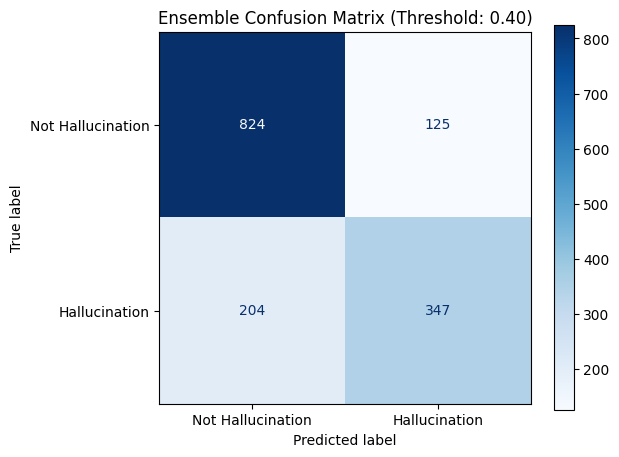

In [9]:
df_deb = pd.read_csv("/kaggle/input/ensemble-probs/submission_deberta.csv")
df_cat = pd.read_csv("/kaggle/input/ensemble-probs/submission_catboost (1).csv")

df_deb['id'] = np.arange(len(df_deb))

df = pd.merge(df_deb, df_cat, on='id')

W_DEB = 0.3
W_CAT = 0.7

df['ensemble_prob'] = (df['deberta_prob'] * W_DEB) + (df['catboost_prob'] * W_CAT)


with open("/kaggle/input/shroom-aware/test.model-aware.json") as f:
    test_data = pd.DataFrame(json.load(f))
    
label_map = {'Hallucination': 1, 'Not Hallucination': 0}
y_true = test_data['label'].map(label_map).fillna(0).astype(int).values

# Search for the best threshold
best_acc = 0
best_thresh = 0.5
thresholds = np.linspace(0.1, 0.9, 81)

for t in thresholds:
    preds = (df['ensemble_prob'] > t).astype(int)
    acc = accuracy_score(y_true, preds)
    
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

print(f"ENSEMBLE RESULTS")
print(f"Best Ensemble Threshold: {best_thresh:.2f}")
print(f"Best Accuracy: {best_acc:.4f}")

final_preds = (df['ensemble_prob'] > best_thresh).astype(int)
final_f1 = f1_score(y_true, final_preds)
final_rho = spearmanr(y_true, df['ensemble_prob'])[0]

print(f"F1 Score: {final_f1:.4f}")
print(f"Spearman: {final_rho:.4f}")

cm = confusion_matrix(y_true, final_preds)

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Not Hallucination', 'Hallucination'])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title(f"Ensemble Confusion Matrix (Threshold: {best_thresh:.2f})")
plt.show()